# Some *tests* for the inner functionality of the whole dqn package

In [ ]:
import os
import sys
import numpy as np

from navigation.envs import mlagents

In [ ]:
# definitions for full paths to executables
EXEC_BANANA_PATH = os.path.join( os.getcwd(), 'executables/Banana_Linux/Banana.x86_64' )
EXEC_BANANA_NOVIS_PATH = os.path.join( os.getcwd(), 'executables/Banana_Linux_NoVis/Banana.x86_64' )

In [ ]:
# initialize the environment
_env = mlagents.createDiscreteActionsEnv( EXEC_BANANA_PATH )
## _env = mlagents.createDiscreteActionsEnv( EXEC_BANANA_NOVIS_PATH )

In [ ]:
print( 'numActions: ', _env.numActions )
print( 'obsShape: ', _env.obsShape )

In [ ]:
_state = _env.reset( training = False )
print( '_state.shape: ', _state.shape )
print( '_state:' )
_raysState = _state[:-2].reshape( 7, -1 )
print( '_raysState: ' )
print( _raysState )

def process( state ) :
    return state[:-2].reshape( 7, -1 )

In [ ]:
_raysState[:,[0,2,4]]

In [ ]:
_state = _env.reset( training = False )

while True :
    
    _action = np.random.randint( _env.numActions )
    _snext, _reward, _done, _ = _env.step( 2 )
    
    print( '#######################' )
    print( '_snext: ' )
    print( process( _snext ) )
    print( '_reward: ', _reward )
    print( '_done: ', _done )
    
    if _done :
        break

_env.close()

## Testing the sumtree data structure

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from navigation.dqn.utils import sumtree

In [19]:
smtree = sumtree.SumTree(8)

smtree.add( 'a', 3 )
smtree.add( 'b', 10 )
smtree.add( 'c', 12 )
smtree.add( 'd', 4 )
smtree.add( 'e', 1 )
smtree.add( 'f', 2 )
smtree.add( 'g', 8 )
smtree.add( 'h', 2 )

In [20]:
print( 'arr-tree: ', smtree._tree )
print( 'data: ', smtree._data )

arr-tree:  [42. 29. 13. 13. 16.  3. 10.  3. 10. 12.  4.  1.  2.  8.  2.]
data:  ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h']


### testing sampling method

In [107]:
_val = 42. * np.random.random()
_indx, _nodeval, _data = smtree.getNode( _val )
print( 'sampled (%s), with nodeval=%.2f and indx=%i, for value=%.2f' % ( _data, _nodeval, _indx, _val )  )

sampled (h), with nodeval=2.00 and indx=14, for value=40.79


### checking the probability distribution given by the node values

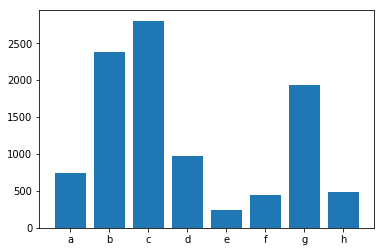

In [106]:
NSAMPLES = 10000
BUCKETS = [0] * len( smtree._data )
for _ in range( NSAMPLES ) :
    _indx, _, _data = smtree.getNode( 42. * np.random.random() )
    BUCKETS[_indx - len( smtree._data ) + 1] += 1
    
plt.bar( ['a','b','c','d','e','f','g','h'], BUCKETS )
plt.show()    